# Tutorial 04: Geometry optimization and transition state search

In this tutorial you will learn more about geometry optimization and we will take a look at computing the transtion state of simple reactions.

In [1]:
import psi4

import numpy as np

## Transition state of the Be + H$_2$ reaction

In this example we will try to find the transition state for the Be + H$_2$ insertion reaction that leads to the H-Be-H molecule.

### Finding a guess for the transition state

To locate the transition state, we will first scan the potential energy surface to indentify an initial guess for the transition state.

We start by defining a function that returns the geometry of BeH$_2$ with the hydrogen in position (±0.7,0,0) Å and the Be atom in position (x,y,0).
All atoms lie in the z = 0 plane.

In [2]:
theorylevel = 'b3lyp/def2-SVP'

def beh2_geom(x,y):
    return psi4.geometry(f"""
    H   0.7  0.000  0.000
    H  -0.7  0.000  0.000    
    Be {x}  {y}  0.000
    symmetry c1    
    """)

Now we can test the function to generate the geometry. If you have `fortecubeview` installed you can just run the following snippet of python code

```python
import fortecubeview
fortecubeview.geom(molecule=beh2_geom(0.5,1.5))
```

and this will generate the following structure

<img src='beh2_test.png' width='200 px'>

In [6]:
# uncomment the next two lines and run this cell only if you have fortecubeview
import fortecubeview
# fortecubeview.geom(molecule=beh2_geom(0.5,1.5))
# print(beh2_geom(0.5,1.5).to_string(dtype='xyz'))
xyz = """
H                     0.291389216757    -1.225832349729     0.000000000000
H                    -1.108610783243    -1.225832349729     0.000000000000
Be                    0.091389216757     0.274167650271     0.000000000000
"""

fortecubeview.geom(xyz=xyz)

Renderer(camera=OrthographicCamera(bottom=-5.0, children=(DirectionalLight(color='white', intensity=0.5, posit…

Let's now look at the potential energy scan as a function of the x and y coordinates of the Be atom.
We're going to scan value of x in the range [0.2,1.2] and y in the range [1.0,2.0]. We intentionally avoid the x = 0 geometries (symmetric) because there are some issues with the electronic structure.

I have generated some data with the following code:

```python 
# Scan the energy as a function of the position of the Be atom
psi4.set_options({'E_CONVERGENCE' : 1.0e-6,'D_CONVERGENCE' : 1.0e-1})
delta = 0.1
x = np.arange(0.2, 1.2, delta)
y = np.arange(1.0, 2.0, delta)
X, Y = np.meshgrid(x, y)

E = np.zeros((10,10))
for i, myx in enumerate(x):
    for j, myy in enumerate(y):
        mol = beh2_geom(myx,myy)
        E[j][i]= psi4.energy(theorylevel,molecule=mol)
```
After running this code I saved the energy to a file (together with the x and y coordinates). The following code load this and plots it

Text(0.5, 1.0, 'Potential energy scan')

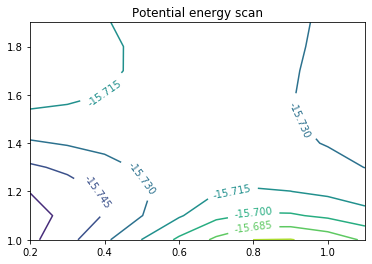

In [7]:
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

X = np.load('X.npy')
Y = np.load('Y.npy')
E = np.load('energy.npy')

fig, ax = plt.subplots()
CS = ax.contour(X, Y, E)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Potential energy scan')

This plot shows the typical structure of a saddle point with the transition state located approximately around x = 0.7 and y = 1.5 Å. In one direction (bottom left <-> top right) the curvature of the energy is **positive**, while in the orthogonal direction (top left <-> bottom right) the curvature is **negative**. We can visualize this guess and it looks like

<img src='beh2_ts_guess.png' width='200 px'>

If you have fortecubeview, you can generate this figure with the command:
```python
ts_guess = beh2_geom(0.7,1.5)
fortecubeview.geom(molecule=ts_guess)
```

In [19]:
# ts_guess = beh2_geom(0.7,1.5)
# fortecubeview.geom(molecule=ts_guess)

### Transition state optimization
Next we will use this structure to perform a transition state search.
However, before we run `psi4.optimize` we need to set a few important options:
- We tell psi4 to run a transition state search with the option `OPT_TYPE`, which we set to `TS` (for transition state).
- We ask psi4 to compute the full hessian at the beginning of the transition state search by setting the vairable `FULL_HESS_EVERY` to 0 (which means compute the Hessian only on the first step of the TS search).
**This option is critical for the success of the TS search, because by default psi4 will use an empirical  Hessian, which is likely to have the wrong eigenvalue structure.** For challenging TS optimizations you could also try to set `FULL_HESS_EVERY` to 2-4, which instructs psi4 to recompute the Hessian every 2-4 geometry steps.

These options can be set with the command:
```python
psi4.set_options({'OPT_TYPE' : 'TS', 'FULL_HESS_EVERY': 0})
```

The next cell performs the transition state search

In [10]:
psi4.set_options({'OPT_TYPE' : 'TS', 'FULL_HESS_EVERY': 0})
psi4.optimize(theorylevel,molecule=ts_guess)

 13 displacements needed.
 1 2 3 4 5 6 7 8 9 10 11 12 13
Optimizer: Optimization complete!


-15.726766179877407

We can now visualize the optimized geometry with the command
```python
fortecubeview.geom(molecule=ts_guess)
```
to get
<img src='beh2_ts_opt.png' width='200 px'>

In [18]:
# fortecubeview.geom(molecule=ts_guess)

This looks like the transition state for the insertion of Be in the H-H bond. Since the optimization converged we know that it is a stationary point. However, we should check that it has one imaginary frequency. We can do this by running a frequency computation.

To visualize the normal modes we are going to tell psi4 to save the normal modes to a file with the command
```python
psi4.set_options({'NORMAL_MODES_WRITE':True})
```
At the end of the computation psi4 will make a file named something like `stdout.default.21138.molden_normal_modes`. The number `21138` in this name is the identification number of the process running psi4.

In [15]:
psi4.set_options({'NORMAL_MODES_WRITE':True})
psi4.frequencies(theorylevel,molecule=ts_guess)

 7 displacements needed.
 1 2 3 4 5 6 7


-15.72676617987761

We can now plot the normal modes with the following code
```python
fortecubeview.vib('stdout.default.21138.molden_normal_modes')
```
which shows this image for the imaginary mode
<img src='beh2_ts_imag_mode.png' width='200 px'>
This figure shows indeed that the transition state corresponds to pulling the two hydrogen atoms apart to insert Be in the H-H bond.

In [7]:
fortecubeview.vib('stdout.default.21138.molden_normal_modes')

HTML(value='\n        <style>\n           .jupyter-widgets-output-area .output_scroll {\n                heigh…

interactive(children=(Select(description='Select:', options=('1: Imaginary mode (i2840.4 cm^-1)', '2: Normal m…

## Next steps

Once you have found a transition state we can compute several quantities:
1. We can compute the energy barrier for the insertion reaction.
1. We can compute the forward and backward IRC path to confirm that this transition state connects to the reactant (Be + H$_2$) and product (H-Be-H).
1. For more complex reactions you might want to search for other reaction paths.